In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.domain import Domain
from src.interpolation import SplineInter
from src.transformations import Affine2d
from src.plotting import view_image_2d, plot_grid_2d
from src.super_resolution_tools import *
from src.transformations import Affine2d
from src.LinearOperator import LinearOperator
from src.lanczos import lanczos_tridiag
# from src.conjugate_gradient import conjugate_gradient
from src.utils import * 
from src.optimization import *
import torch.func as func
from src.distance import SSDDistance
import time

torch.set_default_dtype(torch.float64)

In [2]:
def show_reference_and_templates(R, T):

    # Determine the layout for the subplots
    num_images = 1 + T.shape[0]  # Total number of images (reference + targets)
    cols = int(torch.ceil(torch.sqrt(torch.tensor(num_images).float())))  # Number of columns (and rows in a square layout)
    rows = int(torch.ceil(torch.tensor(num_images).float() / cols))  # Number of rows needed to accommodate all images

    # Create the figure with subplots
    _, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

    # Flatten the ax array for easier indexing
    ax = ax.flatten()

    # Display the reference image
    ax[0].imshow(R.detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
    ax[0].set_title('Reference')
    ax[0].axis('off')  # Optional: hide axes for cleaner visualization

    # Display the target images
    for k in range(T.shape[0]):
        ax[k + 1].imshow(T[k].detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
        ax[k + 1].set_title(f'T_{k}')
        ax[k + 1].axis('off')  # Optional: hide axes for cleaner visualization

    # Turn off any unused subplots
    for i in range(1 + T.shape[0], len(ax)):
        ax[i].axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
    plt.show()

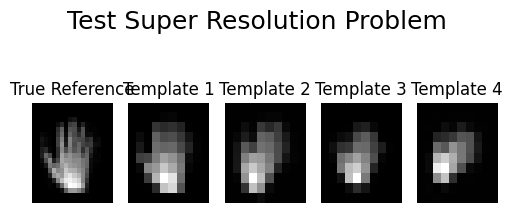

In [6]:
m = 20
factor = 2
theta = 0
n_images = 4

domain_R = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m, m)))
domain_R.m.detach()
domain_T = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m//factor, m//factor)))
xc = domain_R.getCellCenteredGrid().view(-1, 2).to(torch.float64)
times = torch.linspace(0, 15, n_images)

R = Image.open('../data/hands-R.jpg')
R = R.resize((m, m))
R = torch.fliplr(torch.tensor(R.getdata(), dtype=torch.float64).view(m,m).transpose(0,1))
Rimg = SplineInter(R, domain_R ,regularizer='moments',theta=theta).to(torch.float64)

def randomAffines(reference, n):
    affines = [getRandomAffine(rotation_range=(0,45),seed=_+2) for _ in range(n-1)]
    templates = [down_sample(reference(xc).reshape(m, m), factor)]
    for aff in affines:
        affine = Affine2d()
        affine.A = torch.nn.Parameter(aff[0].to(torch.float64))
        affine.b = torch.nn.Parameter(aff[1].to(torch.float64))
        templates.append(down_sample(reference(affine(xc)).reshape(m, m), factor))
    return torch.stack(templates)

T = randomAffines(Rimg, len(times))

#show_reference_and_templates(R, T)

fig, ax = plt.subplots(1, n_images + 1, figsize = (6,2.5))

[a.axis('off') for a in ax]

plt.sca(ax[0])
view_image_2d(R, domain_R)
plt.title("True Reference")

for i in range(n_images):
    plt.sca(ax[i+1])
    view_image_2d(T[i].detach(), domain_T)
    plt.title("Template {}".format(i+1))

plt.suptitle("Test Super Resolution Problem", fontsize=18, y=1.07)

plt.show()

In [7]:
def L_forward(f):
    reference = f.reshape(*domain_R.m)
    diff_0 = torch.diff(reference, dim = 0) / domain_R.h[0]
    diff_1 = torch.diff(reference, dim = 1) / domain_R.h[1]
    return torch.hstack([diff_0.flatten(), diff_1.flatten()])

L = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=L_forward, dtype = torch.float64)

def K_forward(f):
    reference = f.reshape(*domain_R.m)
    downsampled = down_sample(reference, factor).flatten()
    return downsampled.flatten() 

K = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=K_forward, dtype = torch.float64)
# f0_interp = K.T @ T[0].flatten().detach()
Timg = SplineInter(T[0].detach(),domain_T, regularizer='moments', theta=1e-2)
f0_interp = Timg(domain_R.getCellCenteredGrid()).flatten()

d = T.flatten()
b = torch.hstack([d * torch.sqrt(torch.prod(domain_T.h)), torch.zeros_like(L @ f0_interp)])

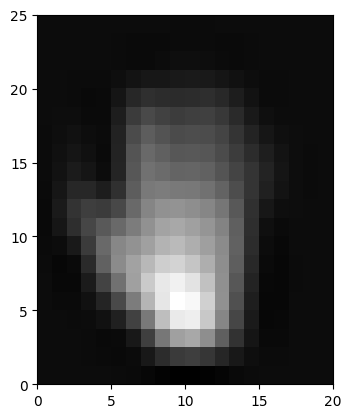

In [8]:
view_image_2d(f0_interp, domain_R)

In [9]:
xc_2d = domain_R.getCellCenteredGrid()
xc = xc_2d.reshape(torch.prod(domain_R.m).item(),2).detach()

ys = [Affine2d() for _ in range(n_images)]
for y in ys:
    for param in y.parameters():
        param.to(torch.float64)
        param.requires_grad_(True)

lam = 1e-2

wps = [{k: v for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec0 = torch.stack(flat_params_list).flatten().unsqueeze(1)


In [10]:
f0_grad = None
f0_nograd = None
def conjugate_gradient(A, b, x0, max_iter=500, tol=1e-3):
    x = x0.clone()
    r = b - A(x)
    p = r.clone()
    rsold = r.dot(r)
        
    for i in range(max_iter):
        Ap = A(p)
        alpha = rsold / p.dot(Ap)
        x = x + alpha * p  
        r = r - alpha * Ap  
        rsnew = r.dot(r)
        if torch.sqrt(rsnew) < tol:
            # print(f"tol reached {i}")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    # print(f"residual norm: {torch.sqrt(rsnew)}")
    return x
    

def conjugate_gradient_nograd(A, b, x0, max_iter=500, tol=1e-3):
    with torch.no_grad():
        x = x0.clone()
        r = b - A(x)
        p = r.clone()
        rsold = r.dot(r)
        for i in range(max_iter):
            Ap = A(p)
            alpha = rsold / p.dot(Ap)
            x = x + alpha * p 
            x = x.detach()
            r = r - alpha * Ap  
            rsnew = r.dot(r)
            if torch.sqrt(rsnew) < tol:
                break
            p = r + (rsnew / rsold) * p
            rsold = rsnew
        # print(f"residual norm: {torch.sqrt(rsnew)}")
        return x

def Forward_single(wp, y, f_inter):
    w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
    yc = func.functional_call(y, w_dict, xc)
    d_pred = K(f_inter(yc))
    return d_pred

def res_fn(wp_vec, cg_iter):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R).to(torch.float64)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0 = conjugate_gradient(A.T ^ A, A.T @ b, f0_interp, max_iter=cg_iter)
    reference = f0.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R).to(torch.float64)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def res_fn_nodiff(wp_vec, cg_iter):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= cg_iter)
    reference = f0.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def Jac_fn(wp_vec, cg_iter):
    return func.jacfwd(res_fn)(wp_vec, cg_iter).detach().squeeze()

def Jac_fn_nodiff(wp_vec, cg_iter):
    return func.jacfwd(res_fn_nodiff)(wp_vec, cg_iter).detach().squeeze()



/tmp/ipykernel_7613/1728885044.py:63: OptimizeWarning: Unknown solver options: gtol
  results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',


1 - Current Loss: 1.1141181829e+06, Norm of Gradient: 1.1789375051e+04
2 - Current Loss: 1.1124516597e+06, Norm of Gradient: 5.4289638776e+03
3 - Current Loss: 1.1005193471e+06, Norm of Gradient: 5.1008958415e+03
4 - Current Loss: 1.1004616733e+06, Norm of Gradient: 2.0625362569e+03
5 - Current Loss: 1.1003527585e+06, Norm of Gradient: 1.7857264412e+03
6 - Current Loss: 1.0993936600e+06, Norm of Gradient: 1.3419276399e+03
7 - Current Loss: 1.0981798328e+06, Norm of Gradient: 9.9635787839e+02
8 - Current Loss: 1.0980755052e+06, Norm of Gradient: 6.1365134572e+02
9 - Current Loss: 1.0980389867e+06, Norm of Gradient: 5.1880270816e+02
10 - Current Loss: 1.0979740203e+06, Norm of Gradient: 3.9359713262e+02
11 - Current Loss: 1.0978842301e+06, Norm of Gradient: 1.8187426075e+02
12 - Current Loss: 1.0978828786e+06, Norm of Gradient: 8.2401264776e+01
13 - Current Loss: 1.0978704388e+06, Norm of Gradient: 6.6607028352e+01
14 - Current Loss: 1.0978497044e+06, Norm of Gradient: 5.5945797545e+01
1

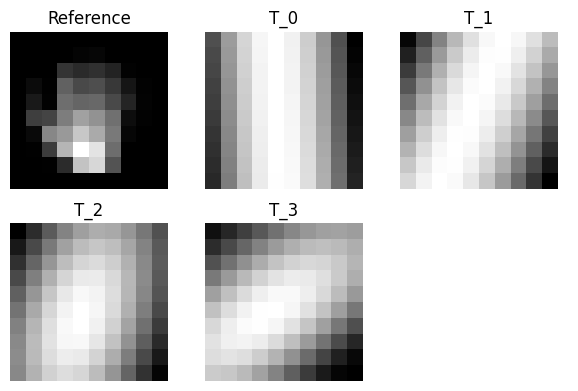

1 - Current Loss: 4.7533400332e+05, Norm of Gradient: 9.5724094710e+04
2 - Current Loss: 4.5178012748e+05, Norm of Gradient: 3.3570233309e+04
3 - Current Loss: 4.4729906697e+05, Norm of Gradient: 1.0298222528e+04
4 - Current Loss: 4.4167792257e+05, Norm of Gradient: 8.0009554743e+03
5 - Current Loss: 4.4165253624e+05, Norm of Gradient: 3.3331752950e+03
6 - Current Loss: 4.4160586737e+05, Norm of Gradient: 2.6821803548e+03
7 - Current Loss: 4.4151880764e+05, Norm of Gradient: 2.2739661705e+03
8 - Current Loss: 4.4137649823e+05, Norm of Gradient: 1.4179891468e+03
9 - Current Loss: 4.4125916320e+05, Norm of Gradient: 3.5244158288e+02
10 - Current Loss: 4.4106651478e+05, Norm of Gradient: 2.2744627992e+03
11 - Current Loss: 4.4102250787e+05, Norm of Gradient: 8.8669832979e+02
12 - Current Loss: 4.4064208995e+05, Norm of Gradient: 4.1198702706e+03
13 - Current Loss: 4.4061234524e+05, Norm of Gradient: 1.2080896580e+03
14 - Current Loss: 4.4055824075e+05, Norm of Gradient: 9.6560806441e+02
1

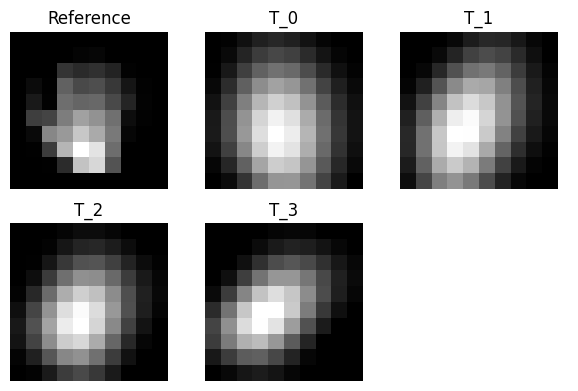

1 - Current Loss: 2.3859510292e+05, Norm of Gradient: 2.5102317592e+05
2 - Current Loss: 1.7705533530e+05, Norm of Gradient: 1.0028464923e+05
3 - Current Loss: 1.6401209647e+05, Norm of Gradient: 2.8563656644e+04
4 - Current Loss: 1.5829728402e+05, Norm of Gradient: 1.7836590270e+04
5 - Current Loss: 1.5133707144e+05, Norm of Gradient: 1.0318019208e+04
6 - Current Loss: 1.5123849617e+05, Norm of Gradient: 3.1881409843e+03
7 - Current Loss: 1.4847504241e+05, Norm of Gradient: 1.6937362769e+04
8 - Current Loss: 1.4808273840e+05, Norm of Gradient: 3.2164357015e+03
9 - Current Loss: 1.4757786593e+05, Norm of Gradient: 1.5208705875e+03
10 - Current Loss: 1.4564614523e+05, Norm of Gradient: 1.0753767517e+04
11 - Current Loss: 1.4538687579e+05, Norm of Gradient: 3.2365014314e+03
12 - Current Loss: 1.4496127918e+05, Norm of Gradient: 2.0560703640e+03
13 - Current Loss: 1.4304469904e+05, Norm of Gradient: 1.6648831482e+04
14 - Current Loss: 1.4258943894e+05, Norm of Gradient: 4.0870193858e+03
1

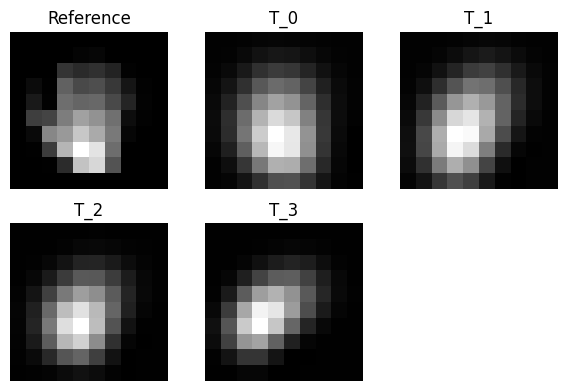

1 - Current Loss: 1.9557890676e+05, Norm of Gradient: 4.3894463698e+05
2 - Current Loss: 1.1828774794e+05, Norm of Gradient: 2.3069915510e+05
3 - Current Loss: 1.0795812560e+05, Norm of Gradient: 8.5933340016e+04
4 - Current Loss: 9.5197099743e+04, Norm of Gradient: 4.6362413263e+04
5 - Current Loss: 9.1491008123e+04, Norm of Gradient: 3.7335215748e+04
6 - Current Loss: 8.4540463597e+04, Norm of Gradient: 3.1554126105e+04
7 - Current Loss: 7.3671101941e+04, Norm of Gradient: 2.0156703467e+04
8 - Current Loss: 6.6502345531e+04, Norm of Gradient: 1.4974117380e+04
9 - Current Loss: 6.3326784455e+04, Norm of Gradient: 9.5581416849e+03
10 - Current Loss: 5.9736644848e+04, Norm of Gradient: 6.8293033850e+03
11 - Current Loss: 5.8308722957e+04, Norm of Gradient: 3.4201836289e+03
12 - Current Loss: 5.5599959776e+04, Norm of Gradient: 5.5235427486e+03
13 - Current Loss: 5.1204568492e+04, Norm of Gradient: 2.8540119408e+04
14 - Current Loss: 4.9243592475e+04, Norm of Gradient: 1.8133598358e+04
1

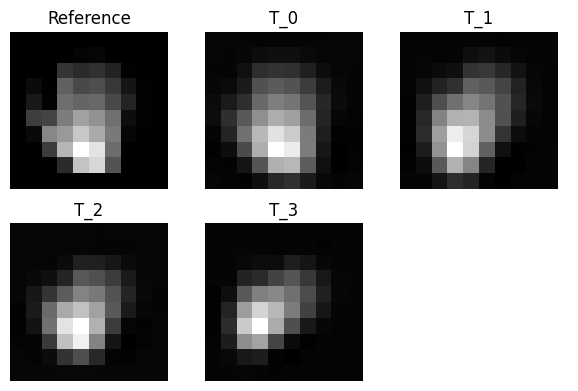

1 - Current Loss: 2.0719582621e+05, Norm of Gradient: 5.0959873907e+05
2 - Current Loss: 1.1395820114e+05, Norm of Gradient: 3.2026345545e+05
3 - Current Loss: 1.0401397736e+05, Norm of Gradient: 1.6929265718e+05
4 - Current Loss: 1.0080893870e+05, Norm of Gradient: 1.4705189867e+05
5 - Current Loss: 9.6079865244e+04, Norm of Gradient: 1.6087412357e+05
6 - Current Loss: 8.7683372236e+04, Norm of Gradient: 1.4014161448e+05
7 - Current Loss: 8.3504854793e+04, Norm of Gradient: 2.7969236925e+05
8 - Current Loss: 7.8272854694e+04, Norm of Gradient: 8.5723755674e+04
9 - Current Loss: 7.5013940681e+04, Norm of Gradient: 3.3178609938e+04
10 - Current Loss: 6.8763630542e+04, Norm of Gradient: 2.9777454501e+04
11 - Current Loss: 5.8230986083e+04, Norm of Gradient: 3.0413173785e+04
12 - Current Loss: 5.0480448990e+04, Norm of Gradient: 2.4058862037e+04
13 - Current Loss: 4.4719551496e+04, Norm of Gradient: 1.2080842939e+04
14 - Current Loss: 4.4603585000e+04, Norm of Gradient: 5.7211406821e+03
1

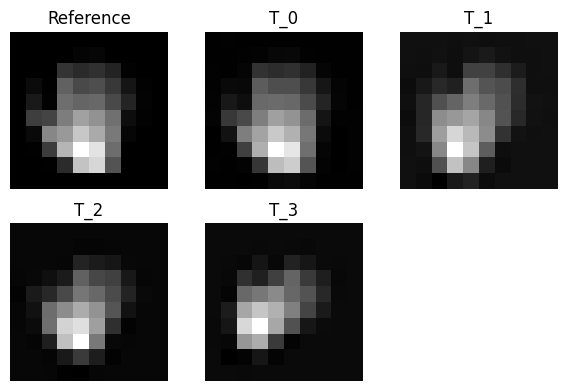

1 - Current Loss: 2.2937120089e+05, Norm of Gradient: 7.0968595874e+05
2 - Current Loss: 1.8000520856e+05, Norm of Gradient: 3.6036267725e+05
3 - Current Loss: 1.5143024662e+05, Norm of Gradient: 4.2221433406e+05
4 - Current Loss: 1.1974245135e+05, Norm of Gradient: 2.1188693256e+05
5 - Current Loss: 1.1255697222e+05, Norm of Gradient: 1.3260843646e+05
6 - Current Loss: 1.0242044665e+05, Norm of Gradient: 1.9100451710e+05
7 - Current Loss: 9.9978189149e+04, Norm of Gradient: 7.5662012116e+04
8 - Current Loss: 9.5637222837e+04, Norm of Gradient: 5.8784686509e+04
9 - Current Loss: 9.0945875708e+04, Norm of Gradient: 3.2841577876e+04
10 - Current Loss: 8.4095136481e+04, Norm of Gradient: 4.3302876160e+04
11 - Current Loss: 8.3928321792e+04, Norm of Gradient: 1.3931920841e+04
12 - Current Loss: 8.2436089816e+04, Norm of Gradient: 1.1569490154e+04
13 - Current Loss: 8.0824509437e+04, Norm of Gradient: 1.8165905802e+04
14 - Current Loss: 7.0824606142e+04, Norm of Gradient: 1.2093237975e+05
1

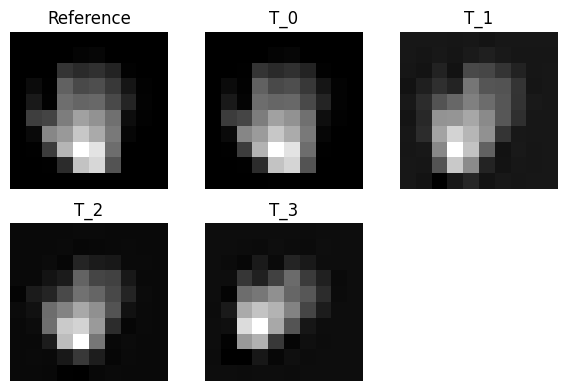

In [11]:
# preregistration

# pre-reg

from scipy.optimize import minimize

def single_img_trafo(wp,y):
    w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
    yc = func.functional_call(y, w_dict, domain_T.getCellCenteredGrid())
    # print(Timg(yc).shape)
    return Timg(yc).flatten()

def lossfn(wp_vec):
    pred_d = torch.hstack([single_img_trafo(wp_vec.reshape(-1,6)[j], ys[j]) for j in range(n_images)])
    return torch.norm(pred_d - d)**2


def scipy_loss(wc):
    global last_loss
    wc_tensor = numpy_to_tensor(wc)
    loss = lossfn(wc_tensor)
    last_loss = loss.item()
    return last_loss

def scipy_grad(wc):
    global last_grad
    wc = numpy_to_tensor(wc)
    grad = torch.func.grad(lossfn, argnums=0)(wc).detach()
    last_grad = tensor_to_numpy(grad)
    return last_grad

def scipy_hessian(wc):
    wc = numpy_to_tensor(wc)
    hessian = torch.func.hessian(lossfn, argnums=0)(wc).detach()
    hessian = .5 * (hessian + hessian.T)
    return tensor_to_numpy(hessian)

def callback(xk):
    norm_grad = np.linalg.norm(last_grad)
    grad_norms.append(norm_grad)
    global iteration_num
    iteration_num+=1
    print(f'{iteration_num} - Current Loss: {last_loss:.10e}, Norm of Gradient: {norm_grad:.10e}')

# multi-scale 

thetas = torch.logspace(2, -3, 6)

for theta in thetas:

    theta_np = tensor_to_numpy(theta)

    last_loss = None
    last_grad = None
    iteration_num = 0

    grad_norms = []

    Timg = SplineInter(T[0].detach(), domain_T,regularizer='moments',theta=theta)
    Rimgs = [SplineInter(T[i], domain_T, regularizer='moments', theta=theta) for i in range(n_images)]
    Rcs = torch.stack([Rimgs[i](domain_T.getCellCenteredGrid()) for i in range(len(Rimgs))])

    results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',
               jac=scipy_grad, hess=scipy_hessian,
               options={'gtol': 1e-2, 'maxiter':50}, callback=callback)
    
    template_predictions = torch.stack([single_img_trafo(numpy_to_tensor(results.x).reshape(-1,6)[j], ys[j]).reshape(*domain_T.m) for j in range(n_images)])
    show_reference_and_templates(T[0], template_predictions)


Checking Derivatives:


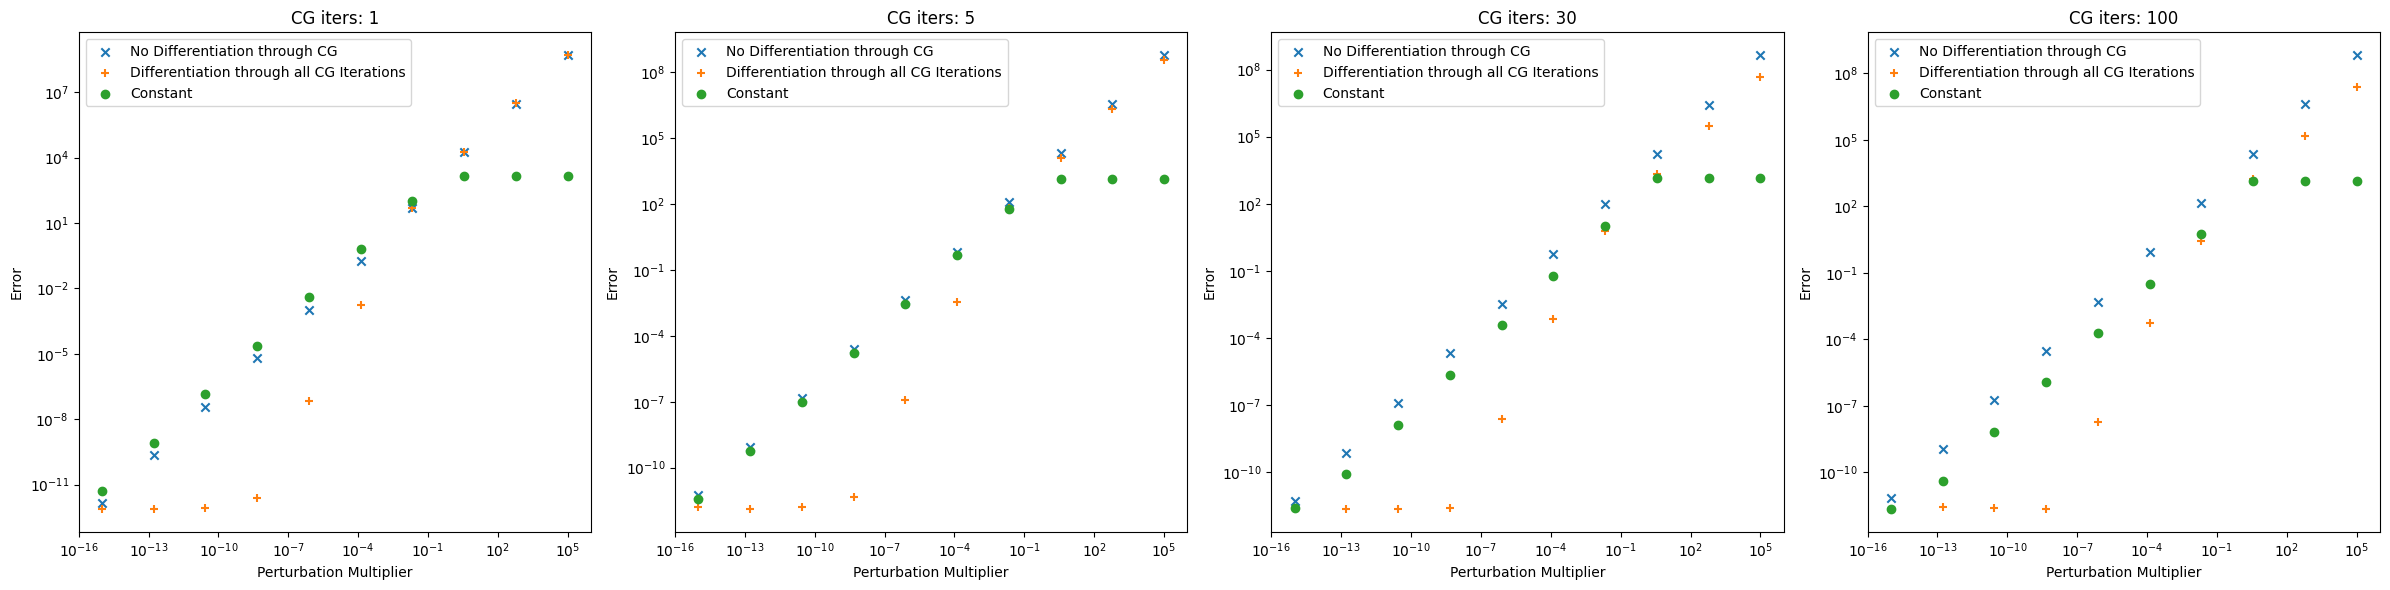

In [10]:
print("Checking Derivatives:")
max_iters = [1, 5, 30, 100]

H = torch.logspace(5,-15,10)
n_plots = 4
fig, axes = plt.subplots(1, n_plots, figsize=(24, 6))
# Loop through each subplot and plot
for i in range(n_plots):
    no_diffs = []
    diffs = []
    const = []
    v = Jac_fn(numpy_to_tensor(results.x), max_iters[i]).T @ res_fn(numpy_to_tensor(results.x), max_iters[i]) # in the direction of the gradient
    v /= torch.norm(v)
    f_x = res_fn(numpy_to_tensor(results.x), max_iters[i])
    Jacv_nodiff = Jac_fn_nodiff(numpy_to_tensor(results.x), max_iters[i]) @ v
    Jacv = Jac_fn(numpy_to_tensor(results.x), max_iters[i]) @ v
    for h in H:
        no_diffs.append(torch.norm(res_fn(numpy_to_tensor(results.x) + h * v, max_iters[i]) - f_x - h * Jacv_nodiff).detach())
        diffs.append(torch.norm(res_fn(numpy_to_tensor(results.x) + h * v, max_iters[i]) - f_x - h * Jacv).detach())
        const.append(torch.norm(res_fn(numpy_to_tensor(results.x) + h * v, max_iters[i]) - f_x).detach())
    axes[i].scatter(H, no_diffs, marker='x', label = 'No Differentiation through CG')
    axes[i].scatter(H, diffs, marker='+', label = 'Differentiation through all CG Iterations')
    axes[i].scatter(H, const, marker='o', label = 'Constant')
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].legend()
    axes[i].set_xlabel("Perturbation Multiplier")
    axes[i].set_ylabel("Error")
    axes[i].set_title(f"CG iters: {max_iters[i]}")
    # view_image_2d(f0_interp_test, domain_R, ax=axes[1,i])
# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

In [12]:
CG_iters = [1, 5, 10, 25, 50, 100]
max_iter = 10

f0_grads = []
loss_grads = []
grad_grads = []

for n_iter in CG_iters:
    wp_list, _, losses, grads  = lsq_lma(numpy_to_tensor(results.x).squeeze(), res_fn, Jac_fn, args=[n_iter], gtol=1e-5, max_iter=max_iter, verbose=False, return_loss_and_grad=True)
    wp_vec = wp_list[-1]
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])
        regularizer = lam * L(f)
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)
    f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= 5000, tol=1e-12)
    f0_grad_reshaped = f0.reshape(*domain_R.m)

    f0_grads.append(f0_grad_reshaped.clone().detach())
    loss_grads.append(losses)
    grad_grads.append(grads)

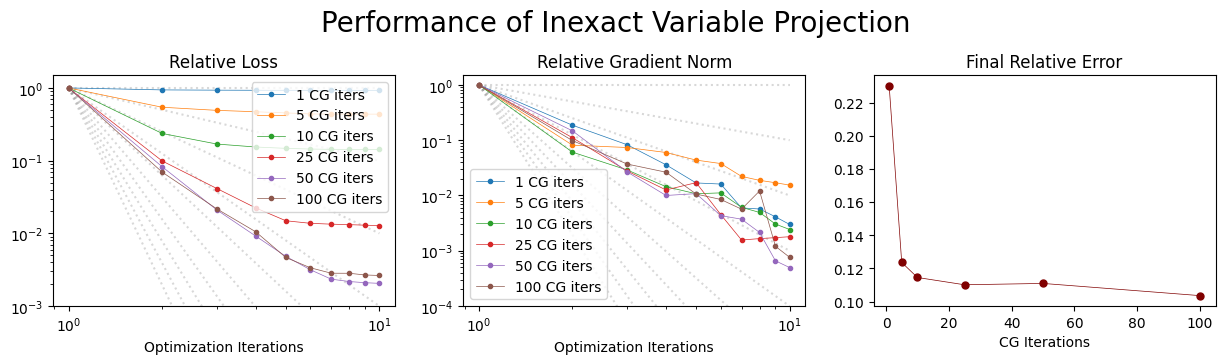

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

plt.sca(ax[0])
for i in range(max_iter):
    plt.loglog(np.arange(max_iter) + 1, 1/(np.arange(max_iter) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(CG_iters)):
    plt.loglog(np.arange(max_iter) + 1, np.array(loss_grads[i])/loss_grads[i][0], label="{} CG iters".format(CG_iters[i]), linewidth=0.5, marker = '.')
plt.legend(loc = 'upper right')
plt.ylim(10e-4,1.5)
plt.title('Relative Loss')
plt.xlabel('Optimization Iterations')

plt.sca(ax[1])
for i in range(max_iter):
    plt.loglog(np.arange(max_iter) + 1, 1/(np.arange(max_iter) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(CG_iters)):
    plt.loglog(np.arange(max_iter) + 1, np.array(grad_grads[i])/grad_grads[i][0], label="{} CG iters".format(CG_iters[i]), linewidth=0.5, marker = '.')
plt.legend()
plt.ylim(10e-5,1.5)
plt.title('Relative Gradient Norm')
plt.xlabel('Optimization Iterations')

plt.sca(ax[2])
plt.plot(CG_iters, np.array([torch.norm(f - R) for f in f0_grads])/torch.norm(R), linewidth=0.5, marker = '.', markersize=10, color='maroon')
plt.title('Final Relative Error')
plt.xlabel('CG Iterations')

plt.suptitle('Performance of Inexact Variable Projection', y = 1.1, size=20)

plt.savefig('../results/figs/CG_iter_test.pdf', bbox_inches='tight')

plt.show()

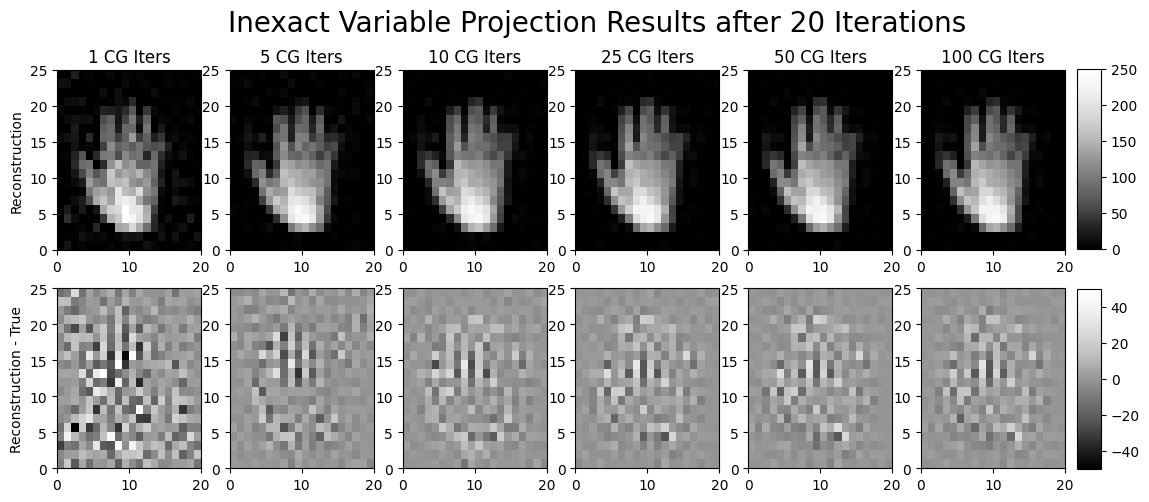

In [22]:
fig, ax = plt.subplots(2, len(CG_iters), figsize=(12,4))

for i in range(len(CG_iters)):
    #ax[0,i].axis('off')
    #ax[1,i].axis('off')

    plt.sca(ax[0,i])
    im_0 = view_image_2d(f0_grads[i],domain_R, kwargs={'clim':(0,250), 'cmap':'Greys_r'})
    plt.title("{} CG Iters".format(CG_iters[i]))

    plt.sca(ax[1,i])
    im_1 = view_image_2d(f0_grads[i] - R,domain_R, kwargs={'clim':(-50,50), 'cmap':'Greys_r'})

ax[0,0].set_ylabel("Reconstruction")
ax[1,0].set_ylabel("Reconstruction - True")

fig.subplots_adjust(0,0,.84,1)

# Create colorbar axes
cbar_ax1 = fig.add_axes([0.85, 0.55, 0.02, 0.45])  # x, y, width, height
cbar_ax2 = fig.add_axes([0.85, 0.0, 0.02, 0.45])

# Create colorbars in the new axes
cbar1 = plt.colorbar(im_0, cax=cbar_ax1)
cbar2 = plt.colorbar(im_1, cax=cbar_ax2)

plt.suptitle('Inexact Variable Projection Results after 20 Iterations', y = 1.15, x=.45, size=20)

plt.savefig('../results/figs/CG_iter_refs.pdf', bbox_inches='tight')

plt.show()
